# Replicating Craig and Rocheteau (2006)

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook I try to replicate some of the results related to the welfare cost of inflation from Craig and Rocheteau (2006) who use the Lagos and Wright (2005) money search model.

## 1. Money Demand data

First, we look at the money demand data used by Lucas (2000).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from lmfit import  Model
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import matplotlib.style
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 8)  # Sets the size of the figures in the notebook

In [2]:
# Importing the data from Lucas (2000)
data = pd.read_table('lucasdata.txt', names = ['Nominal interest rates','Real balances'] ,header = None)

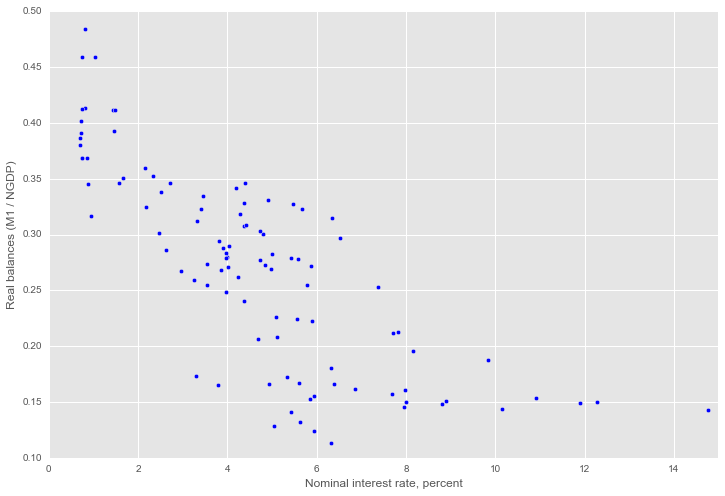

In [3]:
plt.scatter(data['Nominal interest rates']*100,data['Real balances'])
plt.xlim(0,15)
plt.ylim(0.1,0.5)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Real balances (M1 / NGDP)')
plt.show()

## 2. Fitting money demand

Now we try to fit the money demand data with a log-log specification: $m(r) = A r^{-\eta}$ and a semi-log specification: $m(r) = A e^{-\eta r}$. To do this, we use curve_fit, a non-linear least squares curve fitting function from Scipy. Another option would be to use the lmfit package.

In [4]:
from scipy.optimize import curve_fit

def func1(r,A,eta):
    return A * r ** (-eta)

def func2(r,A,eta):
    return A * np.exp(-eta*r)

popt1, pcov1 = curve_fit(func1, data['Nominal interest rates'], data['Real balances'])
popt2, pcov2 = curve_fit(func2, data['Nominal interest rates'], data['Real balances'])
print('log-log specification: A =', popt1[0],' eta =',popt1[1])
print('semi-log specification: A =', popt2[0],' eta =',popt2[1])

log-log specification: A = 0.0978394998068  eta = 0.299522607081
semi-log specification: A = 0.430582904172  eta = 11.0278018694


Next, we plot the two fitted curves along with the data. This is easily done by passing the estimated parameters to the fitted functions and evaluating over the grid of the nominal interest rate.

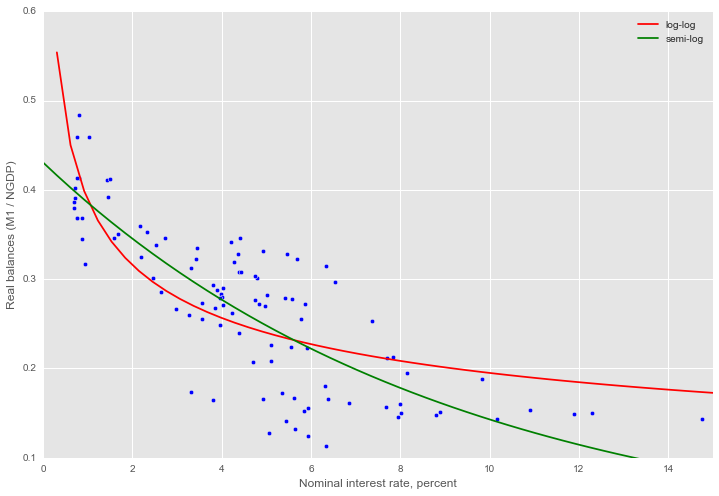

In [5]:
plt.scatter(data['Nominal interest rates']*100,data['Real balances'], label = None)
r = np.linspace(0,0.15)
plt.plot(r*100, func1(r, *popt1), 'r-', label='log-log')
plt.plot(r*100, func2(r, *popt2), 'g-', label='semi-log')
plt.xlim(0,15)
plt.ylim(0.1,0.6)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Real balances (M1 / NGDP)')
plt.legend(loc='best')
plt.show()

## 3. Welfare cost of inflation

In order to calculate the cost of inflation, we consider the welfare cost of raising interest rates from a rate of $r_0 = 3\%$ assumed to correspond to an inflation rate of 0. This is done by measuring the area under the fitted money demand curve for the log-log and semi-log specifications.

In [6]:
from scipy.integrate import fixed_quad as integrate

# Define the function measuring the welfare cost of an increase in interest rates from r0 to r1 
# in terms of the decrease in real balances from m0 to m1
# Since we first approximate the money demand and we need to measure the cost 
# using instead the inverse money demand a little geometric manipulation is needed

# Welfare cost using the log-log specification
def wc1(r1,r0,*popt):  
    integral, err = integrate(lambda r: func1(r, *popt),r0,r1)
    return integral - (r1 - r0) * func1(r1,*popt) + (func1(r0,*popt) - func1(r1,*popt)) * r0

# Welfare cost using the semi-log specification
def wc2(r1,r0,*popt):
    integral, err = integrate(lambda r: func2(r, *popt),r0,r1)
    return integral - (r1 - r0) * func2(r1,*popt) + (func2(r0,*popt) - func2(r1,*popt)) * r0

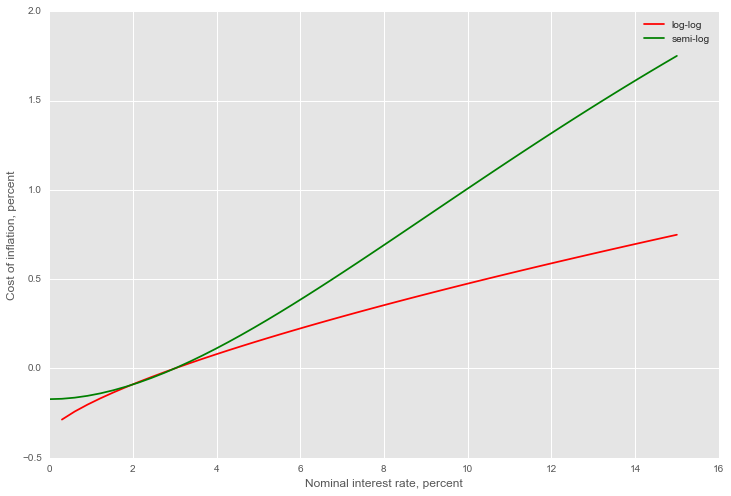

In [7]:
r0 = 0.03
r1 = np.linspace(0,0.15)
plt.plot(r1*100, [wc1(x,r0,*popt1)*100 for x in r1], 'r-', label='log-log')
plt.plot(r1*100, [wc2(x,r0,*popt2)*100 for x in r1], 'g-', label='semi-log')
#plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

## 4. Welfare cost of inflation in the Lagos-Wright model

Now we use the money search model proposed by Lagos and Wright (2005). The Lagos-Wright model can be reduced to one equation which specifies the quantity traded in the decentralized market (DM) where money is essential:
$$ q = \arg \max{\lbrace -rz(q) + \sigma[u(q) - z(q)] \rbrace} $$
where the relationship between $q$ and real balances $z$ depends on the bargaining protocol used to determine the terms of trade in the DM.

The first order condition resulting from the Lagos-Wright model is:
$$r = \sigma \left[ \frac{u'(q)}{z'(q)} - 1 \right]$$

This optimality condition links the individual optimal money holdings $z$ to the cost of carrying money $r$.

The aggregate money demand is defined as: $ L = \dfrac{M}{\sigma M + p A}$ where $A$ is the real output in the centralized market (CM), and $p$ is the price of the general good in the CM. Replacing by the real money balances $ z = M / p$ one gets:
$$L = \dfrac{z}{\sigma z + A}$$ where $z$ is determined by $r$ through the first order condition above. 

In what follows we will explore the welfare cost of inflation based on the Lagos-Wright model using different pricing mechanisms:
* Proportional solution
* Nash bargaining
* Constant mark-up

In order to calibrate the model, we adopt the following functional forms:
$$ u(q) = q^{1-\eta} / (1-\eta) \quad \text{where} \quad \eta \geq 0$$
$$ c(q) = q $$
The matching probability is set to $\sigma = 1/2$.

### 4.1. Proportional bargaining

In the proportional bargaining solution, the buyer obtains a constant fraction $\theta$ of the match surplus:
$$u(q) - z(q) = \theta \left[ u(q) - c(q) \right]$$

This implies the following expression for the terms of trade $(z,q)$:
$$z(q) = (1 - \theta) u(q) + \theta c(q)$$

where $z$ is a function of $q$ and $q^*$ is determined through the first order condition from above:
$$r = \sigma \left[ \frac{u'(q^*)}{z'(q^*)} - 1 \right]$$

Replacing the corresponding functional forms and solving for $q$, we get the efficient quantity $q^*$ as a function of the parameters $\theta$, $\sigma$ and $\eta$ and the nominal interest rate $r$:
$$q^* = \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-1}{\eta}}$$

Plugging $q^*$ into $z(q)$, one gets:
$$z^* = \frac{1-\theta}{1-\eta} \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-(1-\eta)}{\eta}} + \theta \left[ \frac{ \theta(r + \sigma)}{\theta \sigma - (1-\theta)r} \right]^{\frac{-1}{\eta}} $$

Inserting $z^*$ into the aggregate money demand equation $L = \dfrac{z}{\sigma z + A}$, we can estimate the parameters $\eta$ and $A$ for different values of $\theta$ using NLLS.

#### Fitting the data

In [8]:
sigma = 1/2

theta = 1

# Aggregate money demand equation

def func3(r,A,eta):
    z_star = ((1 - theta) / (1 - eta)) * ((theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-(1-eta) / eta)) + theta * ((theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-1 / eta))
    return (sigma + A / z_star) ** (-1)

# Fitting the aggregate money demand equation
# Loop over different values of theta
for theta in [1,0.61, 0.50, 0.33]:
    popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    print('For theta =', theta, ': A =', popt3[0],' eta =',popt3[1])

For theta = 1 : A = 1.82482808098  eta = 0.144223868333
For theta = 0.61 : A = 2.04910736521  eta = 0.223101577165
For theta = 0.5 : A = 2.18738347776  eta = 0.264388598206
For theta = 0.33 : A = 2.64942808907  eta = 0.373275905632


#### Optimal allocation

Now, we determine the allocation $q^*$ for a given interest rate $r$ and bargaining power $\theta$ using the estimated parameters:

In [9]:
def q_star(r):
    return (theta * (r + sigma) / (theta * sigma - (1 - theta) * r)) ** (-1/eta)

for r in [0.13, 0.03]:
    for theta in [1,0.61, 0.50, 0.33]:
        popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
        eta = popt3[1]
        print('For theta =', theta, 'and r = ', r,': q =', q_star(r))

For theta = 1 and r =  0.13 : q = 0.201402221208
For theta = 0.61 and r =  0.13 : q = 0.157116760608
For theta = 0.5 and r =  0.13 : q = 0.133586014701
For theta = 0.33 and r =  0.13 : q = 0.0720947595039
For theta = 1 and r =  0.03 : q = 0.667632708868
For theta = 0.61 and r =  0.03 : q = 0.646291976708
For theta = 0.5 and r =  0.03 : q = 0.634814025493
For theta = 0.33 and r =  0.03 : q = 0.604045497892


We can clearly see that the higher the bargaining power of the buyer and the lower the cost of money the higher is the quantity bought in the DM.

#### Compensated welfare cost

In order to compute the welfare cost of inflation, we use the compensated welfare method which measures the welfare cost of going from a steady state with interest rate $r_0$ to a steady state with a higher rate $r_1$ by the rate of decrease in consumption $\Delta$ which makes consumers indifferent between the two steady states. This measure is based on the [compensating variation](https://en.wikipedia.org/wiki/Compensating_variation) concept introduced by John Hicks (1939). The welfare cost of inflation is defined by:

$$ \sigma \left[u(q_{r_0}-\Delta q_{r_0}) - c(q_{r_0})\right] + (1 - \Delta) A = \sigma \left[u(q_{r_1}) - c(q_{r_1})\right] + A $$

Using the functional forms assumed above, we get the following expression:
$$
\frac{q_{r_0}^{1-\eta}}{1-\eta} (1-\Delta)^{1-\eta} - q_{r_0} - \frac{A}{\sigma} \Delta = \frac{q_{r_1}^{1-\eta}}{1-\eta} - q_{r_1}
$$

In [10]:
import scipy.optimize as opt

def wc_proport(r1,r0,*popt):
    A, eta = popt
    wc = opt.fsolve(lambda delta:((q_star(r0) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star(r1)) ** (1-eta))/(1-eta) - q_star(r0) + q_star(r1),0.001)
    # I provide delta = 0.001 as an initial guess
    return wc

for theta in [1,0.61, 0.5, 0.33]:
    popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    print('For theta = ',theta,' Delta = ','{:04.2f}'.format(float(wc_proport(0.13,0.03,*popt3)*100)),'%')

For theta =  1  Delta =  0.39 %
For theta =  0.61  Delta =  1.35 %
For theta =  0.5  Delta =  2.17 %
For theta =  0.33  Delta =  5.38 %


Using the results above, we can replicate figure 5 of Craig and Rocheteau (2006):

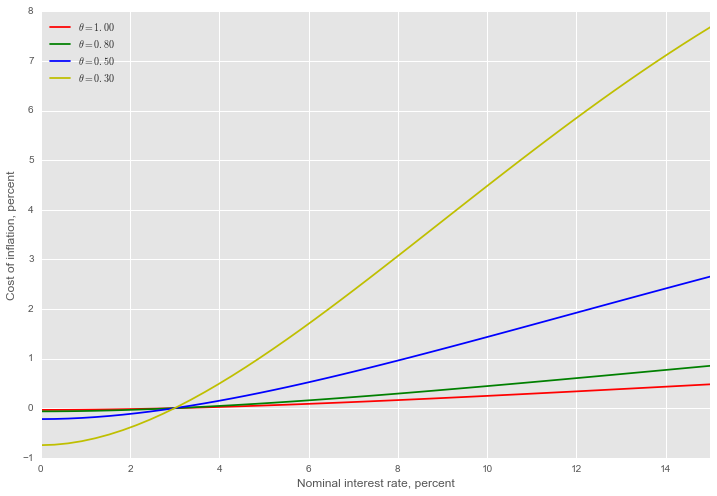

In [11]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b','y'])) # Cycles through colors for the curve
for theta in [1,0.8, 0.5, 0.3]:
    popt3, pcov3 = curve_fit(func3, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    ax.plot(r1*100, [wc_proport(x,r0,*popt3)*100 for x in r1], label=r'$\theta = %.2f$' % theta)
plt.xlim(0,15)
#plt.ylim(-1.5,7)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

As $\theta$ goes from 1 to 0.3, the welfare cost of a 10% increase in inflation goes from slightly below 0.5% of GDP to around 6.5% of GDP.

### 4.2. Nash bargaining

Using the Nash bargaining solution, we have:

$$
z(q) = \frac{\theta u'(q) c(q) + (1-\theta) c'(q) u(q)}{\theta u'(q) + (1- \theta) c'(q)}
$$

and $q^*$ satisfies
$$
\frac{u'(q^*)}{z'(q^*)} = 1 + \frac{r}{\sigma}
$$

Replacing with the functional forms we get:

$$
z(q) = \frac{\theta q^{1-\eta} + (1- \theta) \frac{q^{1-\eta}}{1-\eta}}{\theta q^{-\eta} + 1 - \theta}
$$

and

$$
z'(q) = \frac{(1- \theta)(1-\theta \eta) q^{-\eta} + \theta(1 + (1-\theta) \frac{\eta}{1-\eta})q^{-2\eta}}{(\theta q^{-\eta} + 1 - \theta)^2}
$$

#### Fitting the data

In [62]:
from scipy.misc import derivative

sigma = 1/2

theta = 1

def z_nash(q,eta):
    return (theta * q ** (1-eta) + (1 - theta) * q ** (1-eta) / (1 - eta)) / (theta * q ** (-eta) + 1 - theta)

def dz_nash(q,eta): # First derivative of z(q)
    return (theta * (1 + (eta / (1 - eta)) * (1 - theta)) * (q ** (-2 * eta)) + (1 - theta) * (1 - theta * eta) * (q ** (-eta))) / ((theta * (q ** (-eta)) + 1 - theta) ** 2)

def q_star_nash(r,eta):
    y, = opt.root(lambda q: (q ** (-eta)) / dz_nash(q,eta) - 1 - (r / sigma),1,method='lm').x
#     y = opt.fsolve(lambda q: (q ** (-eta)) / dz_nash(q,eta) - 1 - (r / sigma),1)
#     y, = opt.root(lambda q: (q ** (-eta)) / derivative(z_nash,q,dx=1e-6,args=(eta,)) - 1 - (r / sigma),1,method='lm').x
    return y

# Aggregate money demand equation

def func4(r,A,eta):
    return (sigma + A / z_nash(q_star_nash(r,eta),eta)) ** -1

# Fitting the aggregate money demand equation
# Loop over different values of theta

# # Using curve_fit
# print('Using curve_fit')
# for theta in [1.0, 0.8, 0.5, 0.3]:
#     popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.8,0.2))
#     print('For theta =', theta, ': A =', popt4[0],' eta =',popt4[1])


# Using lmfit
model4 = Model(func4)
print('Using lmfit')
for theta in [1.0, 0.8, 0.5, 0.3]:
    result4 = model4.fit(data['Real balances'],r=data['Nominal interest rates'], A = 1.8, eta = 0.2,method = 'lbfgsb')
    popt4 = list(result4.best_values.values())
    print('For theta =', theta, ': A =', popt4[1],' eta =',popt4[0])

Using lmfit
For theta = 1.0 : A = 1.8102236056  eta = 0.155348898595
For theta = 0.8 : A = 1.80186732964  eta = 0.190746541622
For theta = 0.5 : A = 1.77539529052  eta = 0.293077779085
For theta = 0.3 : A = 1.68154802129  eta = 0.477490149975


#### Optimal allocation

Next, we determine the optimal allocation $q^*$ under different interest rates and $\theta$ values in the same way as in the proportional bargaining part.

In [63]:
# # Using curve_fit
# print('Using curve_fit')
# for r in [0.13, 0.03]:
#     for theta in [1, 0.6, 0.50, 0.34]:
#         popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
#         eta = popt4[1]
#         print('For theta =', theta, 'and r = ', r,': q =', q_star_nash(r,eta))
        
# Using lmfit
model4 = Model(func4)
print('Using lmfit')
for r in [0.13, 0.03]:
    for theta in [1, 0.6, 0.50, 0.34]:
        result4 = model4.fit(data['Real balances'],r=data['Nominal interest rates'], A = 1.8, eta = 0.2,method = 'lbfgsb')
        eta = list(result4.best_values.values())[0]
        print('For theta =', theta, 'and r = ', r,': q =', q_star_nash(r,eta))

Using lmfit
For theta = 1 and r =  0.13 : q = 0.225892824077
For theta = 0.6 and r =  0.13 : q = 0.181517418206
For theta = 0.5 and r =  0.13 : q = 0.159111406303
For theta = 0.34 and r =  0.13 : q = 0.109223871321
For theta = 1 and r =  0.03 : q = 0.687231452285
For theta = 0.6 and r =  0.03 : q = 0.567843524863
For theta = 0.5 and r =  0.03 : q = 0.504770021166
For theta = 0.34 and r =  0.03 : q = 0.319741149046


#### Compensated welfare loss

Now, we compute the compensated welfare loss associated with different levels of the bargaining power $\theta$:

In [64]:
def wc_nash(r1,r0,*popt):
    A, eta = popt
    wc = opt.root(lambda delta:((q_star_nash(r0,eta) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star_nash(r1,eta)) ** (1-eta))/(1-eta) - q_star_nash(r0,eta) + q_star_nash(r1,eta),0.01,method='lm')
    return wc.x

for theta in [1,0.6, 0.5, 0.34]:
    popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
    print('Delta = ','{:04.2f}'.format(float(wc_nash(0.13,0.03,*popt4)*100)),'%')

Delta =  1.83 %
Delta =  3.00 %
Delta =  4.13 %


C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Delta =  5.59 %


C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


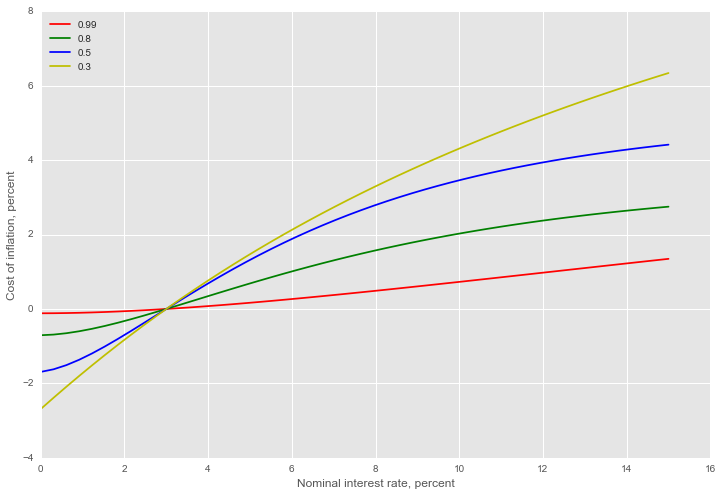

In [35]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b','y'])) # Cycles through colors for the curve
for theta in [0.99,0.8, 0.5, 0.3]:
    popt4, pcov4 = curve_fit(func4, data['Nominal interest rates'], data['Real balances'],(1.2,0.11))
    ax.plot(r1*100, [wc_nash(x,r0,*popt4)*100 for x in r1], label=theta)
#plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()

### 4.3. Constant markup pricing

Finally, I try to compute the welfare cost of inflation using a constant markup pricing instead of an explicit bargaining solution. In this case, the money transfer from the buyer to the seller corresponds to the cost incurred by the seller augmented by a certain percentage $\mu$ with $\mu \geq 0$ such that:

$$
z(q) = (1+\mu)c(q)
$$

and $q^*$ satisfies the usual first order condition:
$$
\frac{u'(q)}{z'(q)} = 1 + \frac{r}{\sigma}
$$

Replacing with the assumed functional forms:
$$
q^* = \left[(1+\mu) (1 + \frac{r}{\sigma})\right]^{-\frac{1}{\eta}}
$$

$$
z(q^*) = (1+\mu)^{\frac{\eta - 1}{\eta}} (1 + \frac{r}{\sigma})^{-\frac{1}{\eta}}
$$

#### Fitting the data

In [36]:
sigma = 1/2

theta = 1

mu = 0.33

def z_star_markup(r,eta):
    return ((1 + mu)**((eta-1)/eta))*((1 + r/sigma)**(-1/eta))

# Aggregate money demand equation

def func5(r,A,eta):
    return (sigma + (A / z_star_markup(r,eta))) ** (-1)

# Fitting the aggregate money demand equation
# Loop over different values of theta
for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.1))
    print('For mu =', mu, ': A =', popt5[0],' eta =',popt5[1])

For mu = 0 : A = 1.82482676902  eta = 0.144223633924
For mu = 0.1 : A = 1.03660357503  eta = 0.144224192254
For mu = 0.2 : A = 0.618568857861  eta = 0.144224080557


#### Optimal allocation

Now, we determine the allocation $q^*$ for a given interest rate $r$ and bargaining power $\theta$:

In [37]:
def q_star_markup(r,eta):
    return ((1 + mu)*(1 + r/sigma))**(-1/eta)

for r in [0.13, 0.03]:
    for mu in [0, 0.1, 0.2]:
        popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
        eta = popt5[1]
        print('For mu =', mu, 'and r = ', r,': q =', q_star_markup(r,eta))

For mu = 0 and r =  0.13 : q = 0.201402221208
For mu = 0.1 and r =  0.13 : q = 0.104007580565
For mu = 0.2 and r =  0.13 : q = 0.056891902445
For mu = 0 and r =  0.03 : q = 0.667632708868
For mu = 0.1 and r =  0.03 : q = 0.344775467428
For mu = 0.2 and r =  0.03 : q = 0.188591791284


#### Compensated welfare loss

In [38]:
def wc_markup(r1,r0,*popt):
    # This function solves for delta
    # I provide delta = 0.001 as an initial guess
    A, eta = popt
    wc = opt.fsolve(lambda delta:((q_star_markup(r0,eta) ** (1-eta)) / (1 - eta)) * ((1 - delta) ** (1 - eta)) - A * delta / sigma - ((q_star_markup(r1,eta)) ** (1-eta))/(1-eta) - q_star_markup(r0,eta) + q_star_markup(r1,eta),0.001)
    return wc

for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    print('Delta = ','{:04.2f}'.format(float(wc_markup(0.13,0.03,*popt5)*100)),'%')

Delta =  1.47 %
Delta =  2.45 %
Delta =  3.26 %


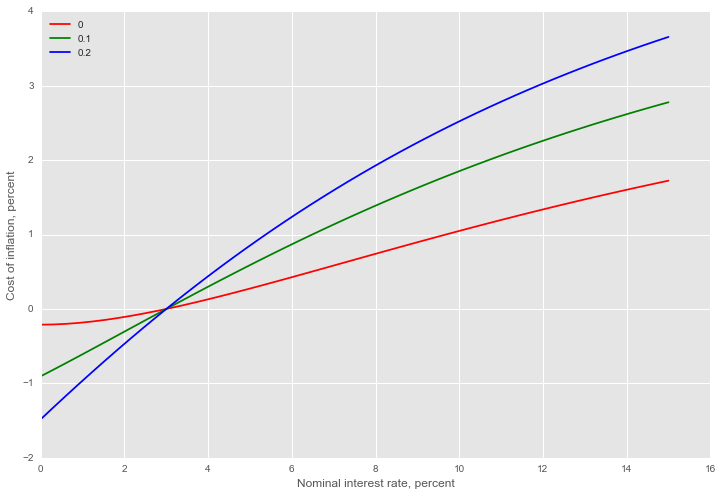

In [39]:
# Plotting the results
r0 = 0.03
r1 = np.linspace(0,0.15)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['r', 'g', 'b'])) # Cycles through colors for the curve
for mu in [0, 0.1, 0.2]:
    popt5, pcov5 = curve_fit(func5, data['Nominal interest rates'], data['Real balances'],(2,0.11))
    ax.plot(r1*100, [wc_markup(x,r0,*popt5)*100 for x in r1], label=mu)
#plt.xlim(0,15)
#plt.ylim(-0.5,2)
plt.xlabel('Nominal interest rate, percent')
plt.ylabel('Cost of inflation, percent')
plt.legend(loc='best')
plt.show()